# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Homework 7: Generative Models - GANs


**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Pavlos Protopapas and Mark Glickman<br/>

**DISCLAIMER**: No public reproduction of this homework nor its solution is allowed without the explicit consent of their authors.

<hr style="height:2pt">

---



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- Please restart the kernel and run the entire notebook again before you submit. 

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f"The R^2 is {R:.4f}")
```
- Your plots should be clearly labeled, including clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is NOT a descriptive title; "95% confidence interval of coefficients of polynomial degree 5" on the other hand is descriptive).

<hr style="height:2pt">

### Learning Objectives



<hr style="height:2pt">

<a id="contents"></a>

## Notebook Contents 

- [**Part 0 (Set Up Notebook)**](#part0)


- [**PART 1 [ 20 pts ]: Preprocess and Visualize data**](#part1)
  - [Overview](#part1intro)
  - [Questions](#part1questions)
  - [Solutions](#part1solutions) 
  
- [**PART 2 [ 20 pts ]: GANs**](#part2)
  - [Overview](#part2intro)
  - [Questions](#part2questions)
  - [Solutions](#part2solutions)

<hr style="height:2pt">

In [2]:
# DO NOT DELETE THIS CELL
# Load useful libraries
import numpy as np
import pandas as pd
import zipfile
import os
import tqdm
import pathlib
import time

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
import tensorflow_datasets as tfds

# Plotting libraries
from matplotlib import pyplot as plt

plt.gray() #set colormap to gray 

<Figure size 432x288 with 0 Axes>

**Check availability of GPU**

Run this line to verify your environment lists an available GPU.

In [3]:
# DO NOT DELETE THIS CELL
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---

In [4]:
!nvidia-smi

Sun May  1 00:14:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    22W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# DO NOT DELETE THIS CELL
# Run this cell to define our download_celeb function

def download_celeb(
    url, 
    filename,
    filepath,
    dirname,
    dirpath,
    chunk_size=1204,
    overwrite=False,
):
    """Downloads and extracts CelebA dataset from CS109B S3 bucket"""
    
    # Do not download if data already exists and overwrite==False
    if not overwrite and os.path.isdir(os.path.join(dirpath, "2.0.1")):
        print(
            "Congratulations...the CelebA dataset already exists "
            "locally!\nNo new downloads are required :o)\n"
        )
    # Download and extract CelebA if it doesn't already exist
    else:
        print("Downloading CelebA dataset to {}\n".format(filepath))

        with requests.get(url, stream=True) as r:
            chunk_size = 1024
            length = int(r.headers['content-length'])
            print(
                "...downloading a {:.2f} GB file."
                "This is going to take a while!".format(length/1e9)
            )
            time.sleep(0.5)
            with open(filepath, 'wb') as f:
                for chunk in tqdm.tqdm(
                    r.iter_content(chunk_size=chunk_size),
                    total=int(length/chunk_size),
                    unit="KB"
                ):
                    f.write(chunk)

        print("...{} download complete :o)".format(filename))

        if not os.path.isdir(dirpath):
            os.makedirs(dirpath)

        print(
            "...extracting {}. This will take a while too :o(\n"
            "".format(filename)
        )

        with zipfile.ZipFile(filepath, 'r') as zipobj:
            zipobj.extractall(dirpath)

        print(
            "The CelebA dataset has been extracted to:"
            "\n\n\t{}\n".format(dirpath)
        )

In [6]:
%%time
# DO NOT DELETE THIS CELL
# Download the CelebA dataset from the CS109B S3 bucket
url = "https://cs109b-prod-course-data.s3.amazonaws.com/CelebA/2.0.1.zip"
filename = "2.0.1.zip"
dirname = os.path.join('data','celeb_a')
working_dir = pathlib.Path().absolute()

dirpath = os.path.join(working_dir, dirname)
filepath = os.path.join(working_dir, filename)

# Running on JupyterHub with data
if os.path.isdir('/home/course_data/celeb_a/2.0.1/'):
    data_dir = '/home/course_data'
# Running anywhere else
else:
    data_dir = os.path.join(working_dir, "data")
    download_celeb(url, filename, filepath, dirname, dirpath)


...downloading a 1.31 GB file.This is going to take a while!


1282632KB [00:43, 29723.00KB/s]                             


...2.0.1.zip download complete :o)
...extracting 2.0.1.zip. This will take a while too :o(

The CelebA dataset has been extracted to:

	/content/data/celeb_a

CPU times: user 30.4 s, sys: 5.13 s, total: 35.5 s
Wall time: 55.2 s


In [7]:
# DO NOT DELETE THIS CELL
# Run this cell
# GANs do not use validation data, so we will ignore the validation set
train_celeb, _ = tfds.load('celeb_a', 
                           split=['train', 'validation'], 
                           shuffle_files=False,
                           data_dir = data_dir, 
                           download=False)

In [8]:
# DO NOT DELETE THIS CELL
# Global variables to define training/loading models. 
# Modify as required. These are only suggested parameters.

TRAIN = True
EPOCHS = 5  # number of epochs to train models
BATCH_SIZE = 32
INPUT_SIZE = (64, 64, 3)  # images will be cropped and resized to `input_size`.

<hr style="height:2pt">

<a id="part1"></a>

# PART 1. Preprocess and Visualize the data


[Return to contents](#contents)



<a id="part1intro"></a>

## Overview

CelebA has 202,599 face images of various celebrities and training on the whole set requires large computational resources to fit your models. For this reason we recommend cropping the images and resizing them to reduce the computational costs. Feel free to adjust the image resolution depending on your computation capabilities. We recommend using `image_size = (64,64,3)`, but feel free to use a larger resolution, or smaller (but no smaller than `image_size = (32,32,3))`.


We provide the function `tf_norm_crop_resize_image` to normalize image pixels between `[0,1]`, to crop the height and width of images to `150x150` pixels, and to [resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) images to the indicated size in the function call. Follow the intructions below to format your data for the GAN model you will need to train:

<a id="part1questions"></a>

## PART 1: Questions

<a id="q11"></a>
**[1.1:](#s11)**  Create a training Dataset pipeline named `train_ds` from `train_celeb`. Basic DCGANs only need images as input to train, so you should ignore the attributes and simply return batches of images. 

Make sure the Dataset follows the format: 1) In this order, normalize, crop, and resize using [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) the data, 3) apply [batching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), 4) optionally use [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) 




<a id="q12"></a>
**[1.2:](#s12)** Verify that your pipeline is working correctly by plotting 5 random images from `train_ds` in a single row.


In [9]:
# DO NOT DELETE THIS CELL
# Use this function to normalize, crop and resize your images.
def tf_norm_crop_resize_image(image, resize_dim):
    """Normalizes image to [0.,1.], crops to dims (150, 150, 3)
    
    and resizes to `resize_dim`, returning an image tensor."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, 150, 150)
    image = tf.image.resize(image, resize_dim)
    image.set_shape(resize_dim + (3,))
    return image

<a id="part1solutions"></a>

## PART 1: Solutions

[Return to contents](#contents)



<a id="s11"></a>
<div class='exercise-r'>

**[1.1:](#q11)** 
Create a training Dataset pipeline named `train_ds` from `train_celeb`. Basic DCGANs only need images as input to train, so you should ignore the attributes and simply return batches of images. 

Make sure the Dataset follows the format: 1) In this order, normalize, crop, and resize using [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) the data, 3) apply [batching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), 4) optionally use [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) 

    
</div>


In [10]:
train_celeb
print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



In [11]:
train_celeb.take(1)

<TakeDataset element_spec={'attributes': {'5_o_Clock_Shadow': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Arched_Eyebrows': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Attractive': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Bags_Under_Eyes': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Bald': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Bangs': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Big_Lips': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Big_Nose': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Black_Hair': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Blond_Hair': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Blurry': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Brown_Hair': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Bushy_Eyebrows': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Chubby': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Double_Chin': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Eyeglasses': TensorSpec(shape

In [12]:
# 1.1
# Your Code Here --------------------------------------------------
def do_mapping(element):
#     print(element)
    image = element['image']
    element['image'] =  tf_norm_crop_resize_image(image, (64, 64))
    return element['image']
    
    
train_ds = train_celeb \
    .map(do_mapping, num_parallel_calls=AUTOTUNE) \
    .shuffle(buffer_size=1000, reshuffle_each_iteration=True) \
    .batch(BATCH_SIZE) \
    .prefetch(AUTOTUNE)


In [13]:
train_ds

<PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

<a id="s12"></a>
<div class='exercise-r'>

**[1.2:](#q12)** Verify that your pipeline is working correctly by plotting 6 random images from `train_ds` in a single row.

</div>

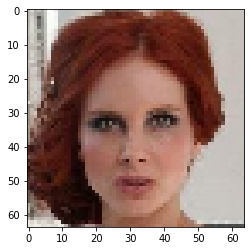

In [14]:
plt.imshow(list(train_ds.take(1))[0][0])

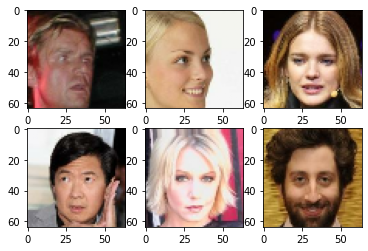

In [15]:
# 1.2
# Your Code Here --------------------------------------------------
rand_imgs = list(train_ds.take(3))[0]
fig, ax = plt.subplots(2, 3)
for i in range(6):
    j = i % 2
    k = i // 2 
    ax[j][k].imshow(rand_imgs[i])



<hr style="height:2pt">

<a id="part2"></a>

# PART 2. Generative Adversarial Networks

[Return to contents](#contents)


<a id="part2intro"></a>
## Overview
For the final exercise we are going to create a standard GAN composed of a generator network, and a discriminator network. GANs are tricky to train, so we encourage you to follow the given instructions for the deep convolutional GAN (DCGAN) when building your architecture and training your models.

However, feel completely free to explore and present other architectures if they present better results. For instance, you can instead build a Wasserstein GAN (WGAN), as was illustrated in lab. Just be certain to split the different components of your GAN (i.e. generator, discriminator, training step, and training) among the appropriate parts of Question 5 below. 

<a id="part2questions"></a>

## PART 2: Questions

<a id="q21"></a>
**[2.1:](#s51)** First create a convolutional Keras generator model. You'll need to specify a 3-tuple called `latent_dim`. Ex: `(8,8,256)`. This will be the shape of the tensor flowing through your generator when it is first reshaped to be 3-D (a kind of proto-image). We recommend the following architecture. 

- The input to the generator should be a noise vector of size `128` (recommended) 
- `Dense` layer with `latent_dim[0]*latent_dim[1]*latent_dim[2]` units, and `LeakyReLU`
- `Reshape` to three dimensional `latent_dim`
- 3 `UpSampling2D` layers each followed by a `Conv2D` layer with 128 filters, 4x4 kernels, 1x1 strides, `'same'` padding, followed by `LeakyReLU`. Adjust the `Conv2D` parameters and activation appropriately in the final layer.
    
Compile and print the summary of your model.
    
**Note: Assign your generator loss and optimizers to unique variables that can be called later in the assignment.** 

<a id="q22"></a>
**[2.2:](#s52)** Create a convolutional discriminator model with at least 3 `Conv2D` layers. Our recommended setup is to use 3 `Conv2D` layers with filters of size `(4,4)`, `'same'` padding, strides 2x2, and `LeakyReLU` activations. Using binary cross-entropy and an optimizer of your choice, assign the discriminator loss and optimizer to unique variables names. Compile and then print the model summary. 

<a id="q23"></a>
**[2.3:](#s53)** Now that we have created both the generator and discriminator models, we will define a training step function used for training the DCGAN. For this problem, complete the partial function below using `tf.GradientTape`.  Make sure to set `training=True` when using your models to create logits.
    
**Note: We are using `@tf.function` to compile the function. This decorator requires that we reference our models and their components from the global scope of the notebook.** 

<a id="q24"></a>
**[2.4:](#s24)** With the training step function defined, we can now train your DCGAN using the CelebA images in your `train_ds` dataset. You should display images from your generator after every training epoch to visualize performance. "Sensible" images should appear with 5 or fewer epochs, especially if you train on the full dataset. Consider training on a subset of the full dataset if it takes too long.  

To train your DCGAN model, you will not be able to use the [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. Instead, you should call your `training_step()` function. Datasets are iterable, so you can use them directly in a for-loop to obtain mini-batches.  You will need to take these steps inside your for-loop: 

1. Create a set of **soft labels** representing your real and fake label values. 

2. Pass a batch of images, along with the labels to your `training_step` function. 

3. Generate and plot 8 images after each epoch of training. 

**You must show at least 8 generated images from your fully trained DCGAN for submission**. 

<a id="q25"></a>
**[2.5:](#S25)** You have gone through and created your first DCGAN, but think back to the CelebA dataset that was imported at the start of the assignment. Each image came with a set of variables defining certain characteristics of the image. That is, it would say if the person was smiling, wearing glasses, etc.. In 3-5 sentences, describe how you would have to modify your models and training_step function to create a conditional GAN? 

<a id="q26"></a>
**[2.6:](#s26)** Standard GANs are composed as a generator and discriminator, as you just coded them. Could we substitute the discriminator with something else, like a KL loss with the empirical distribution? Why or why not? Explain your answer.

<a id="part2solutions"></a>

## PART 2: Solutions

[Return to contents](#contents)

<a id="s21"></a>
<div class='exercise-r'>

**[2.1:](#q21)** First create a convolutional Keras generator model. You'll need to specify a 3-tuple called `latent_dim`. Ex: `(8,8,256)`. This will be the shape of the tensor flowing through your generator when it is first reshaped to be 3-D (a kind of proto-image). We recommend the following architecture. 

- The input to the generator should be a noise vector of size `128` (recommended) 
- `Dense` layer with `latent_dim[0]*latent_dim[1]*latent_dim[2]` units, and `LeakyReLU`
- `Reshape` to three dimensional `latent_dim`
- 3 `UpSampling2D` layers each followed by a `Conv2D` layer with 128 filters, 4x4 kernels, 1x1 strides, `'same'` padding, followed by `LeakyReLU`. Adjust the `Conv2D` parameters and activation appropriately in the final layer.
    
Compile and print the summary of your model.
    
**Note: Assign your generator loss and optimizers to unique variables that can be called later in the assignment.** 
</div>

In [16]:
# 2.1
# Your Code Here --------------------------------------------------
# Create generator model 


# code inspired by lab 
# https://colab.research.google.com/drive/1osImVjP-Rm77IFu73UqyuISa3GUzRoFn?usp=sharing

noise_dim = 128

def generator_model(noise_dim):

  
  latent_dim = (8,8,256)
  # Model input
  input = tf.keras.Input(shape=[noise_dim])

  hidden = tf.keras.layers.Dense(units=latent_dim[0]*latent_dim[1]*latent_dim[2], use_bias=False)(input)
  #hidden = tf.keras.layers.BatchNormalization()(hidden)
  hidden = tf.keras.layers.LeakyReLU()(hidden)
  hidden = tf.keras.layers.Reshape(target_shape=latent_dim)(hidden)


  # block 1
  hidden = tf.keras.layers.UpSampling2D()(hidden)
  hidden = tf.keras.layers.Conv2D(filters=128, 
                                              kernel_size=(4,4), 
                                              strides=(1,1), 
                                              padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.2)(hidden)


  # block 2
  hidden = tf.keras.layers.UpSampling2D()(hidden)
  hidden = tf.keras.layers.Conv2D(filters=128, 
                                              kernel_size=(4,4), 
                                              strides=(1,1), 
                                              padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.2)(hidden)

  # block 3
  hidden = tf.keras.layers.UpSampling2D()(hidden)
  output = tf.keras.layers.Conv2D(filters=3, 
                                              kernel_size=(4,4), 
                                              strides=(1,1), 
                                              padding='same',
                                              activation='tanh')(hidden)
  # hidden = tf.keras.layers.LeakyReLU(alpha=0.2)(hidden)


  # Build the Model
  model = tf.keras.Model(inputs=input, outputs=output, name="Generator")

  return model

In [17]:
generator_ = generator_model(noise_dim)
generator_.summary()


Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 16384)             2097152   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 128)       524416    
                                                         

<a id="s22"></a>
<div class='exercise-r'>

**[2.2:](#q22)** Create a convolutional discriminator model with at least 3 `Conv2D` layers. Our recommended setup is to use 3 `Conv2D` layers with filters of size `(4,4)`, `'same'` padding, strides 2x2, and `LeakyReLU` activations. Using binary cross-entropy and an optimizer of your choice, assign the discriminator loss and optimizer to unique variables names. Compile and then print the model summary. 
</div>

In [18]:
# 2.2
# Your Code Here --------------------------------------------------
def discriminator_model():
  # Model input
  input = tf.keras.Input(shape=[64, 64, 3])

  # block 1
  hidden = tf.keras.layers.Conv2D(filters=64, 
                                    kernel_size=(4,4), 
                                    strides=(2, 2), 
                                    padding='same',
                                    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0,stddev=0.02))(input)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.2)(hidden)
  hidden = tf.keras.layers.Dropout(0.3)(hidden)

  # block 2
  hidden = tf.keras.layers.Conv2D(filters=128,
                                    kernel_size=(4,4), 
                                    strides=(2, 2), 
                                    padding='same', 
                                    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0,stddev=0.02))(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.2)(hidden)
  hidden = tf.keras.layers.Dropout(0.3)(hidden)

  # block 3
  hidden = tf.keras.layers.Conv2D(filters=128,
                                    kernel_size=(4,4), 
                                    strides=(2, 2), 
                                    padding='same', 
                                    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0,stddev=0.02))(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.2)(hidden)
  hidden = tf.keras.layers.Dropout(0.3)(hidden)

  hidden = tf.keras.layers.Flatten()(hidden)
  
  output = tf.keras.layers.Dense(units=1)(hidden)

  model = tf.keras.Model(inputs=input, outputs=output, name="Discriminator")
  return model

In [19]:
discriminator_ = discriminator_model()
adam_optimizer = tf.keras.optimizers.Adam(1e-4) 
loss_ce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# discriminator_.compile(loss=loss_ce, optimizer=adam_optimizer, metrics=['accuracy'])

print(discriminator_.summary())

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)     

<a id="s23"></a>
<div class='exercise-r'>

**[2.3:](#q23)** Now that we have created both the generator and discriminator models, we will define a training step function used for training the DCGAN. For this problem, complete the partial function below using `tf.GradientTape`.  Make sure to set `training=True` when using your models to create logits.
    
**Note: We are using `@tf.function` to compile the function. This decorator requires that we reference our models and their components from the global scope of the notebook.** 
</div>

In [20]:
tf.config.run_functions_eagerly(True)
generator_opt = adam_optimizer
discriminator_opt = adam_optimizer

In [21]:
@tf.function
def training_step(img_batch, true_labels, fake_labels):
    """
    Use tf.GradientTape to train both the generator and discriminator on
    a batch of images. Calculate the losses and then apply the gradients
    to each optimizer to update the weights. 
    
    Parameters:
        img_batch : single batch of images from a tf.data.DataSet pipeline
        real_labels : vector of labels for real images
        fake_labels : vector of labels for fake images

    Returns:
        None
    """
    # 2.3
    # Your Code Here --------------------------------------------------
    # create a cross entropy loss function
    loss_ = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # get gradient tape for generator and discriminator
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:

      gen_img = generator_(noise, training=True)

      real_output = discriminator_(img_batch, training=True)

      fake_output = discriminator_(gen_img, training=True)

      gen_loss = loss_(true_labels, fake_output)

      discr_loss = loss_(true_labels, real_output) +  loss_(fake_labels, fake_output)

    g_gradients = generator_tape.gradient(gen_loss, generator_.trainable_variables)
    d_gradients = discriminator_tape.gradient(discr_loss, discriminator_.trainable_variables)

    generator_opt.apply_gradients(zip(g_gradients, generator_.trainable_variables))
    discriminator_opt.apply_gradients(zip(d_gradients, discriminator_.trainable_variables))

<a id="s24"></a>
<div class='exercise-r'>

**[2.4:](#q24)** With the training step function defined, we can now train your DCGAN using the CelebA images in your `train_ds` dataset. You should display images from your generator after every training epoch to visualize performance. "Sensible" images should appear with 5 or fewer epochs, especially if you train on the full dataset. Consider training on a subset of the full dataset if it takes too long.  

To train your DCGAN model, you will not be able to use the [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. Instead, you should call your `training_step()` function. Datasets are iterable, so you can use them directly in a for-loop to obtain mini-batches.  You will need to take these steps inside your for-loop: 

1. Create a set of **soft labels** representing your real and fake label values. 

2. Pass a batch of images, along with the labels to your `training_step` function. 

3. Generate and plot 8 images after each epoch of training. 

**You must show at least 8 generated images from your fully trained DCGAN for submission**.  
</div>

In [22]:
def plotting_images(image):
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(image[0, :, :, :])
  plt.axis('off')
  plt.show()

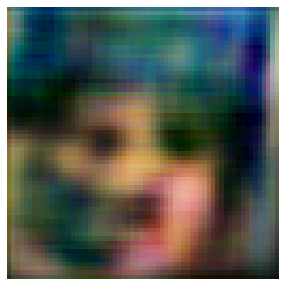

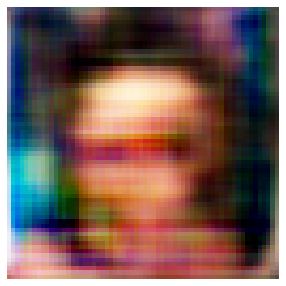

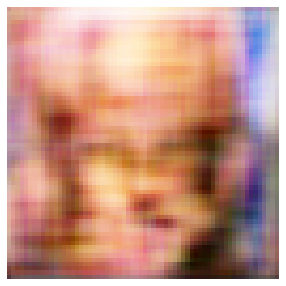

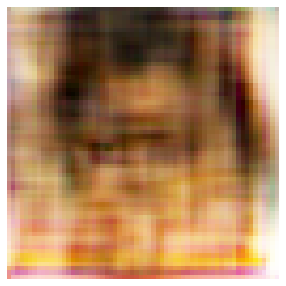

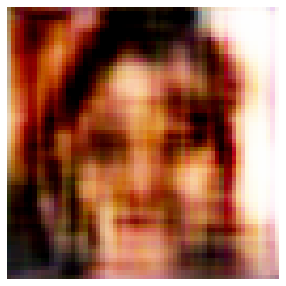

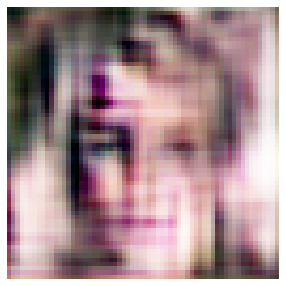

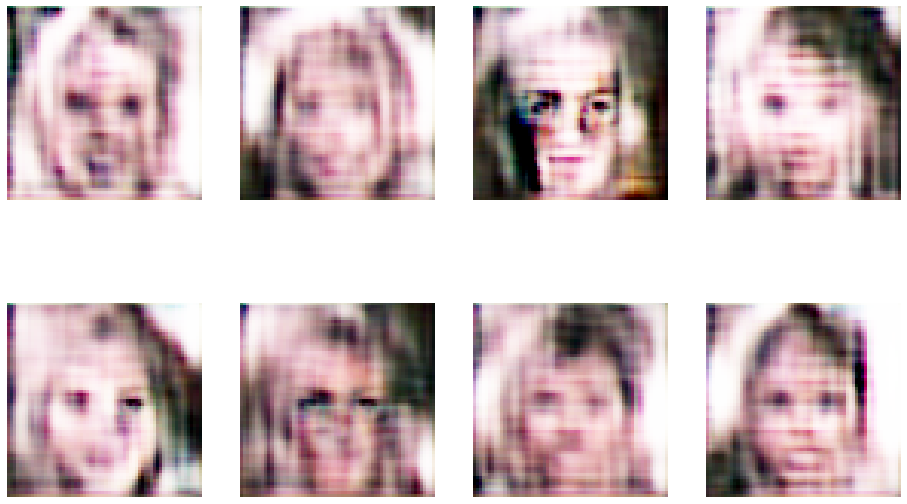

In [23]:
# 2.4
# Your Code Here --------------------------------------------------

for epoch in range(6):

    for batch in train_ds.take(1000):
      training_step(batch,tf.ones(shape=(batch.shape[0],1)),tf.zeros(shape=(batch.shape[0],1)))

    generated_im = generator_(tf.random.normal([1, noise_dim]), training=False)
    plotting_images(generated_im)

generated_images_ = generator_(tf.random.normal([8, noise_dim]), training=False)
fig, ax = plt.subplots(2,4,figsize=(16,10))
for i,ax in enumerate(ax.flatten()):
  ax.imshow(generated_images_[i, :, :, :])
  ax.axis('off')

<a id="s25"></a>
<div class='exercise-r'>

**[2.5:](#q25)** You have created your first DCGAN, but think back to the CelebA dataset that was imported at the start of the assignment. Each image came with a set of variables defining certain characteristics of the image. That is, it would say if the person was smiling, wearing glasses, etc.. In 3-5 sentences, describe how you would have to modify your models and training_step function to create a conditional GAN? 
</div>

**RESPONSE**: In order to change this to be a conditional GAN I would have to modify: the generator,  the discriminator models, and the train step. 

First, I would have to pair up/concatenate the appropriate label to the input image to the discriminator and the noise for the generator. 

Then, create an embedding for the respective label it is to be conditioned on.

The image and the labels embeddings would be sent to the network.

Given this, when this model is generating an image, it would be grasping from an area of the latent space that is associated with that label.


<a id="s26"></a>
<div class='exercise-r'>

**[2.6:](#q26)** Standard GANs are composed as a generator and discriminator, as you just coded them. Could we substitute the discriminator with something else, like a KL loss with the empirical distribution? Why or why not? Explain your answer.
</div>

**RESPONSE**:


The KL (Killback-Leibler) divergence quantifies how much on probability distribution differs from another probability distribution. 

On the other hand, the distriminator is the part of the architecture that has to determine whether the given image is real or not real.

If we were to replace the discriminator with a KL loss, we would be comparing and making the generator generate images whose distribution would be similar to the distribution of the real input images. 

This is definitely possible - but this could however cause problems. To note, the KL divergence is a $divergence$, not a $distance$. This is because the formula for the KL divergence is asymmetric, i.e. one distribution could be over-considered compared to another. In our case, this can cause a problem because the intent is to measure the similarity between two distribution while considering them equally important. 

Given this downside of KL divergence, these papers [1][2] use instead Jensen-Shannon Divergence as measure of similarity between two probability distributions, because it's symmetric and smoother. 


Despite this, the Jensen-Shannon divergence can still fail in case the generated image has a distribution far away from the ground truch. Hence,  recent literature has explored amother distribution divergence metrics, i.e. the Wasserstein Distance (or Earth Mover) distance, that lead to the WGAN. This has a smoother gradient everywhere, hence WGAN learns no matter the generator is performing or not.


[1] https://arxiv.org/pdf/1406.2661.pdf 
[2] https://arxiv.org/pdf/1511.05101.pdf 


